## Project 6

**Mohammad Kamal Sadeghabadi Farahani**

### Description

In this project we have implemented STDP and FlatSTDP learning rules, then we will create a network with two output neurons and two diffrent input patterns and use STDP in our network to learn these patterns.

### Training technique

We will use the following technique for training our network: in equal intervals (say each 100 ms) we will switch between three kind of inputs, firts we will input the pattern1 then we will input the pattern2 and then we will input nothing (zero input) to network for resting and forgotting spike tarces, we will continue this rhythm of giving input to network for the whole of training time. 

In [2]:
import torch
import sys
import copy

sys.path.insert(0, '../../')

from cnsproject.plotting.plotting import raster_plot, plot_weights
from cnsproject.encoding.encoders import PoissonEncoder
from cnsproject.network.neural_populations import InputPopulation, LIFPopulation
from cnsproject.network.connections import DenseConnection
from cnsproject.learning.learning_rules import STDP, FlatSTDP

In [3]:
def train_network_STDP(time, dt, tau_s, max_spikes, lr, switch_interval, LEARNING_RULE):
    pattern1 = torch.tensor([1, 1, 0, 0])
    pattern2 = torch.tensor([0, 0, 1, 1])
    
    min_val = 0
    max_val = 1
    steps = int(time / dt)
    
    tau = 0.1
    threshold = -60
    rest_potential = -65
    
    encoder = PoissonEncoder(time=time, max_spikes=max_spikes, dt=dt)
    coded1 = encoder(min_val, max_val, pattern1)
    coded2 = encoder(min_val, max_val, pattern2)
    
    input_pop = InputPopulation(pattern1.shape, dt=dt, tau_s= tau_s)
    output_pop = LIFPopulation((2,), dt=dt, tau_s=tau_s, threshold=threshold, rest_potential=rest_potential, tau=tau)
    
    synapse = DenseConnection(input_pop, output_pop, lr=lr, learning_rule=LEARNING_RULE)
    
    weights = []
    for i in range(int(steps / switch_interval)):
        for j in range(i * switch_interval, (i + 1) * switch_interval):
            spike_effects = synapse.compute(input_pop.s)
            synapse.update()

            selector = i % 3
            if selector == 0:
                spikes = coded1[j]
            elif selector == 1:
                spikes = coded2[j]
            else:
                spikes = torch.zeros(len(coded2[j]))

            input_pop.forward(spikes, None)
            output_pop.forward(torch.zeros(output_pop.shape), spike_effects)

            weights.append(copy.deepcopy(synapse.weight))
    
    print('Weights changes plot:')
    plot_weights(weights, dt)
    
    
    test_time = 1
    steps_test = int(test_time / dt)
    encoder_test = PoissonEncoder(time=test_time, max_spikes=int(max_spikes * (time / test_time)  ), dt=dt)
    coded_test1 = encoder(min_val, max_val, pattern1)
    coded_test2 = encoder(min_val, max_val, pattern2)
    
    spikes_in = []
    spikes_out = []

    for i in range(int(steps_test / switch_interval)):
        for j in range(i * switch_interval, (i + 1) * switch_interval):
            spike_effects = synapse.compute(input_pop.s)

            selector = i % 2
            if selector == 0:
                spikes = coded_test1[j]
            elif selector == 1:
                spikes = coded_test2[j]

            input_pop.forward(spikes, None)
            output_pop.forward(torch.zeros(output_pop.shape), spike_effects)

            spikes_in.append(input_pop.s)
            spikes_out.append(output_pop.s)

    
    print('Rater plot of testing with patterns: ')
    raster_plot([spikes_in, spikes_out], dt)

### STDP

### Experiment 1

Weights changes plot:


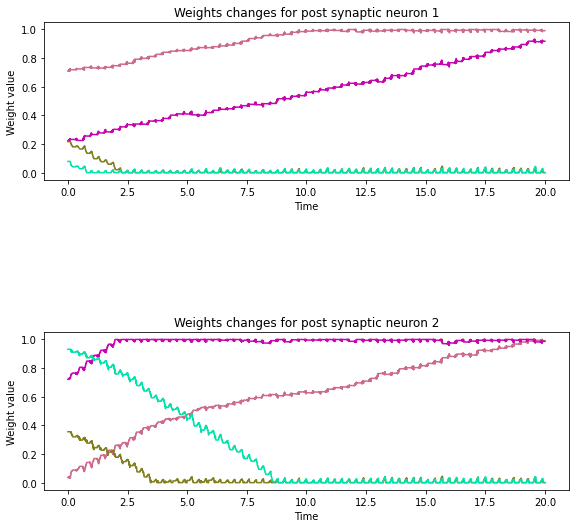

Rater plot of testing with patterns: 


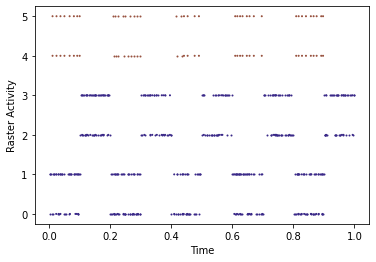

In [3]:
train_network_STDP(20, 0.001, 0.1, 5000, 1, 100, STDP)

### Analysis of experiment 1

| training time | switch interval | $\tau_s$ | learning rate | r_max |
| ------------- | --------------- | -------- | ------------- | ----- |
|     20**s**   |    100 **ms**   |    0.1   |      1        |  5000 |

As we can see in the weights plot, the weights from neurons in input population that produce spikes for the pattern 1 has increased as time goes and converged to 1, and  weights from neurons in input population that produce spikes for the pattern 2 decreased as time goes and converge to 0. this indicates that our network is learning the diffrence between the pattern 1 and 2, and this fact is reflected in raster plot for test input data which shows that under the pattern 1 both output neurons activate and under pattern 2 both output neurons deactivate.
the process of changing weights is as follows:

1. In this interval the neurons that produce pattern 1 (neurons 1 and 2 in input population) start to spiking this will lead to increase in spike traces of neurons 1 and 2 in input population and because these neurons are connected to output neurons the output neurons will activate and thus the spike trace of output neurons will increase, because both populations are spiking in a more or less equal rate and the weights will not change a lot in this interval.

2. In the next interval we will activate input neurons that produce pattern 2 (neurons 3 and 4) now at the start of this interval the spike trace of output neurons as a result of previous activations is a high value and the trace of neurons 3 and 4 is a small value (zero at the start) the spiking of neurons (3 and 4) will lead to spiking of output neurons but now beause the output neurons have a higher amount of trace this activation will lead to decrease of weights between input neurons 3,4 and ouput neurons, at this stage the input neurons 1 and 2 have high amount of spike tarce due to previous activity but they dont spike in this interval thus each spike of ouput neurons will lead to raise in value of weights between input neurons 1,2 and output neurons.

3. In the next interval we will give a rest to network so the spike traces will decay and we can repeat this process again (if we don't give a rest time to network to forget spike traces the weights will oscillate and don't change much).

### Experiment 2

Weights changes plot:


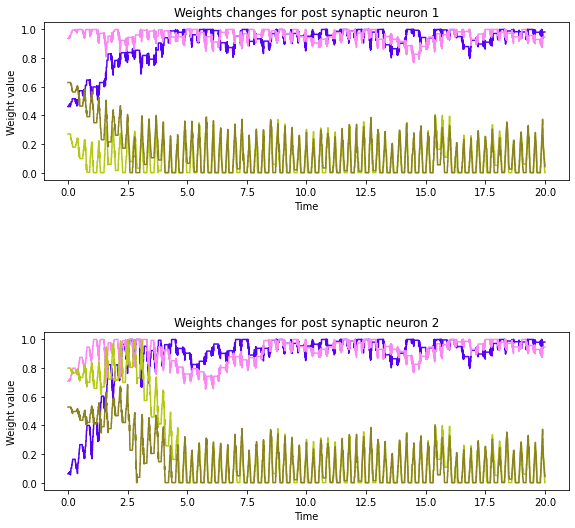

Rater plot of testing with patterns: 


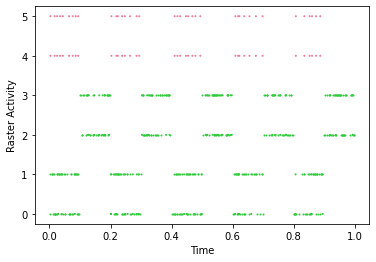

In [17]:
train_network_STDP(20, 0.001, 0.5, 5000, 1, 100, STDP)

### Analysis of experiment 2

| training time | switch interval | $\tau_s$ | learning rate | r_max |
| ------------- | --------------- | -------- | ------------- | ----- |
|     20**s**   |    100 **ms**   |    0.5   |      1        |  5000 |

Here we have the phenomenon as experiment 1 but here beacuse we have a five time bigger value of $\tau_s$ the 100ms of time for resting is not sufficient to for populations to forget spike traces and thus we have a higher oscillation in weights here.

### Experiment 3

Weights changes plot:


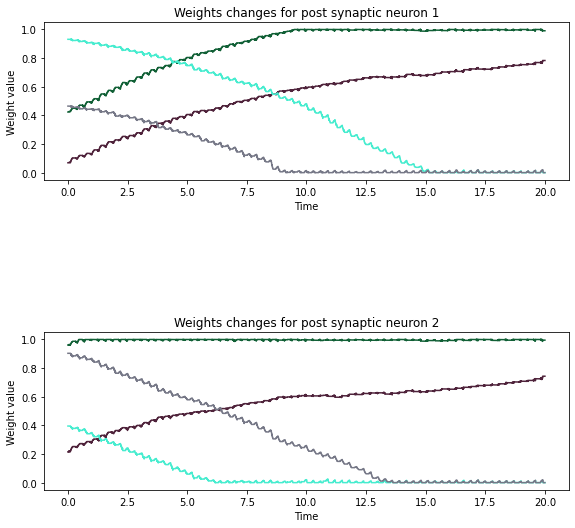

Rater plot of testing with patterns: 


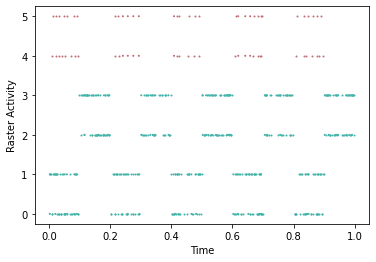

In [18]:
train_network_STDP(20, 0.001, 0.1, 5000, 0.5, 100, STDP)

### Analysis of experiment 3

| training time | switch interval | $\tau_s$ | learning rate | r_max |
| ------------- | --------------- | -------- | ------------- | ----- |
|     20**s**   |    100 **ms**   |    0.1   |      0.5        |  5000 |

As we can see in this experiment we have a lower learning rate compared to experiment 1 so the learning process is slower.

### Flat STDP

In the flat STDP we will not have a trace decay (thus $\tau_s$ is effectless) and rather we will consider spikes in a small time window and based on them change the weights by a constant value.

### Experiment 1

Weights changes plot:


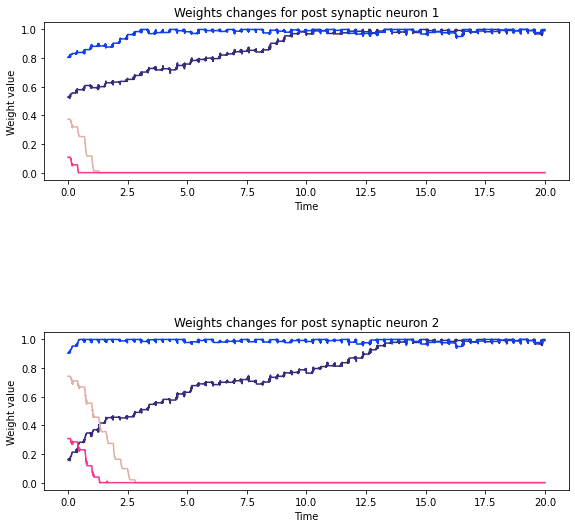

Rater plot of testing with patterns: 


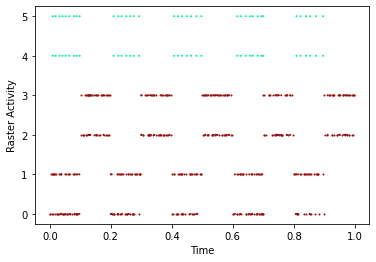

In [6]:
train_network_STDP(20, 0.001, 0.1, 5000, 1, 100, FlatSTDP)

### Analysis of experiment 1

| training time | switch interval | learning rate | r_max |
| ------------- | --------------- | ------------- | ----- |
|     20**s**   |    100 **ms**   |       1       |  5000 |

As we can see here in flat STDP the result is very much like the normal STDP but here because the $\tau_s$ and trace decay is effectless, we can see that we have less oscillation in weights and that's because the spike trace is almost completly forgotten in rest time, because the rest time is longer than falt STDP time window (our default time window in flat STDP is 100ms), beacuse of these situations and plus we will add a constant value to weights in LTD and LTP processes each time, the weights will converge faster.

### Experiment 2

Weights changes plot:


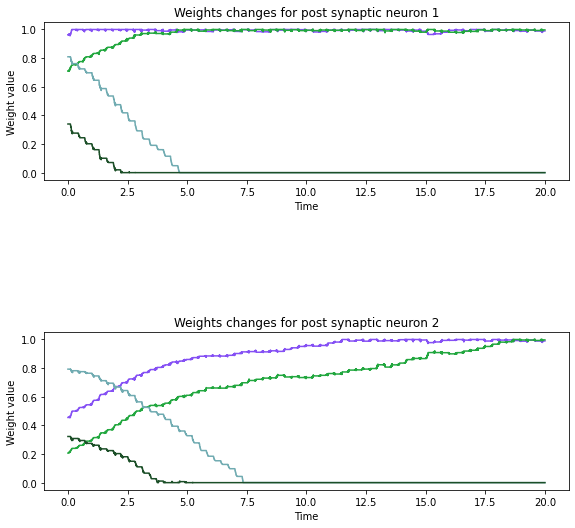

Rater plot of testing with patterns: 


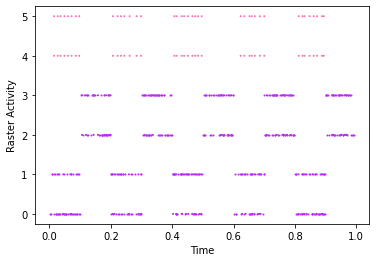

In [5]:
train_network_STDP(20, 0.001, 0.1, 5000, 0.5, 100, FlatSTDP)

### Analysis of experiment 2

| training time | switch interval | learning rate | r_max |
| ------------- | --------------- | ------------- | ----- |
|     20**s**   |    100 **ms**   |       0.5       |  5000 |

Here we have the same story as previous experiment but because the learning rate is smaller, the weights converge slower.